## Benchmarking the promoter sequences of the CRISPROff Screen

In [1]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 
import pprint
import requests

n_sequences = 20883


In [118]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.set_printoptions(threshold=sys.maxsize)


### Import Sequences from server

In [2]:
Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)
Data = Data.sort_values(["gene",'average phenotype of strongest 3'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
what = pd.read_csv('idk.txt', delimiter = '\t',header = 0)
what = what.drop_duplicates() 

errors = []

for gene in (Data['gene']):
        try:
                if len(what[what['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"]) > 1:
                        x = abs(what[what['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"] - Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1]).min()
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = (int(Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1] - int(x) + 1))
                else:
                        x = what[what['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"].iloc[-1]
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = int(x) + 1 
              

        except:
            errors.append(gene)

len(errors)

1568

In [1095]:
Data = Data.reset_index()

In [1096]:
pp = pprint.PrettyPrinter()

b = []

for i, x in enumerate(Data['gene']):
    try:
        datas = requests.get('http://togows.org/api/ucsc/hg19/'+ str(Data['chromosome'][i])+':'+str(int(Data["Primary TSS, 3'"][i]-1500))+'-'+str(Data["Primary TSS, 3'"][i]+1500)).text.replace('\n','')    
        b.append(Data['gene'][i])
        b.append(datas)
    except:
        print('There was an error with:',Data['gene'][i],'. With coordinates:', Data['chromosome'][i], Data["Primary TSS, 3'"][i])

#It took 106 minutes to comlpete all the sequences for 2.5 kb, but this run was with 3 kb

There was an error with: DHX15 . With coordinates: chr4 24529088
There was an error with: SPATA25 . With coordinates: chr20 44515130
There was an error with: SPG20 . With coordinates: chr13 36920574


In [63]:
Promoter_sequences.columns

Index(['Unnamed: 0', 'Gene', 'Sequences'], dtype='object')

### Save the ~20,000 Sequences into a file

In [1141]:
Promoter_sequences = pd.DataFrame()

for i in range(len(b)):
    Promoter_sequences[i] = pd.DataFrame(b)

Promoter_sequences = pd.DataFrame(b[::2], columns= ['Gene'])
Promoter_sequences['Sequences'] = b[1::2]

Promoter_sequences

Promoter_sequences.to_csv(r'3kb_Promoter.sequences-2.csv') # this was done after the sequences were updated with the actual TSS

TypeError: object of type 'numpy.float64' has no len()

In [61]:
Promoter_sequences = pd.read_csv('3kb_Promoter.sequences-2.csv', sep=',', header = 0)
#Promoter_sequences  = pd.concat([Promoter_sequences, Data], axis =1, join="inner")
#Promoter_sequences = Promoter_sequences.drop_duplicates(subset = 'Gene')
Promoter_sequences = pd.merge(how = 'outer', left = Promoter_sequences, right = Data, left_on = 'Gene', right_on = 'gene')
#Promoter_sequences

### Benchmark for the %GC Rich content

In [4]:
counts = Promoter_sequences.Sequences.apply(lambda x: (x.count('G') + x.count('C'))/30)
counts

1        39.033333
2        40.366667
3        45.866667
4        58.600000
5        50.300000
           ...    
19181    53.433333
19182    49.000000
19183    65.800000
19184    46.866667
19185    32.200000
Name: Sequences, Length: 17613, dtype: float64

### Load data from suppelemntal figures of paper

In [5]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = pd.DataFrame(cpgs)

(-0.8, 0.2, -0.8, 0.2)

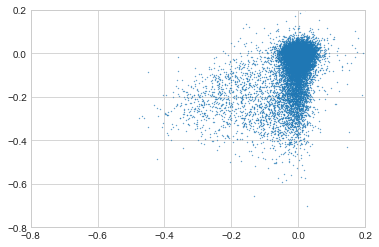

In [5]:
# from math import sqrt

# for i in range(21240):

#     if CpGs['mutant_average'][i] > CpGs['CRISPRoff_average'][i]:
#         CpGs.at[i, 'Phe_sco_pos_neg'] =  int(1)
#         CpGs.at[i,'Strength'] =  sqrt(abs(CpGs['mutant_average'][i] - CpGs['CRISPRoff_average'][i])) 

#     elif CpGs['mutant_average'][i] < CpGs['CRISPRoff_average'][i]:
#         CpGs.at[i, 'Phe_sco_pos_neg'] = int(0)
#         CpGs.at[i,'Strength'] = 0
#     else:
#         CpGs.at[i, 'Strength'] = 'Same'

import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(cpgs['mutant_average'], cpgs['CRISPRoff_average'],s = 0.1)
         
plt.axis([-0.8,0.2,-0.8,0.2])


In [6]:
cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')

### Merging sequences with correspondent phenotype scores

In [7]:
df = pd.merge(how = 'outer', left = Promoter_sequences, right = cpgs, left_on = 'Gene', right_on = 'gene')
df = df.loc[df.Gene.notna()]
df['GC'] = counts
df

,Unnamed: 0,Gene,Sequences,gene_x,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'",...,average phenotype of strongest 3,sgRNA count_MW,sgRNA count_avg,-log10 MW,discScore,thres,gene_y,CRISPRoff_average,mutant_average,GC
0,1.0,A1CF,TGGGTTAAGCACTGTAAAGTTGTTATAGCAATAAACCTATGAAATA...,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822.0,58858172.0,...,0.000262,10.0,10.0,0.443579,0.006050,False,A1CF,0.021009,0.031239,NaN
1,2.0,A2M,GCAACATGCCCCTTGCTCCCCACAGGGAGAGAAGAGCTCTGGCCCT...,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379.0,52601584.0,...,-0.009390,10.0,10.0,0.838166,0.409634,False,A2M,0.012236,0.010139,39.033333
2,3.0,A2ML1,AAGGATTTAAGTAATAATAAAACTCCAGTCTCCCACACAGCCGGCT...,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507.0,9220304.0,...,-0.023705,9.0,9.0,0.961305,1.186075,False,A2ML1,0.006076,0.017281,40.366667
3,4.0,A3GALT2,CCTGCTATCGCCCCCAGGCCAGAAAATGTCATTTTGGACTTTGTCT...,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206.0,8975150.0,...,-0.003734,10.0,10.0,0.360295,0.070022,False,A3GALT2,0.045413,0.018161,45.866667
4,5.0,A4GALT,GTGGCTGAGAGGGTCTGGTAAGGTCAGGTAACAGTGTCTGGCTTAA...,A3GALT2,ENST00000442999.3,chr1,-,Annotation,33786698.0,33772367.0,...,-0.007984,10.0,10.0,0.054850,0.022794,False,A4GALT,-0.143399,-0.134314,58.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17608,19181.0,ZYG11A,ATTGGGCAAAAGCCGAGGAAATGACTGTAACTTTCCTTCATCCTCG...,UBR5,P1P2,chr8,-,"CAGE, matched peaks",103424916.0,103264502.0,...,-0.064363,10.0,10.0,3.516255,11.779312,True,ZYG11A,0.020289,-0.005404,NaN
17609,19182.0,ZYG11B,GAACTGAGGAGGATTTGATGTTAGCTAAAAGACAAATAATTAACTT...,UBR7,P1P2,chr14,+,"CAGE, matched peaks",93673574.0,93673401.0,...,-0.004766,10.0,10.0,0.316341,0.078465,False,ZYG11B,0.012916,-0.027637,56.866667
17610,19183.0,ZYX,GAGCAGGGGAGAATGAAGAGGCGTCAGTTTGGGCATCAGGCTGGAT...,UBTD1,P1P2,chr10,+,"CAGE, matched peaks",99258637.0,99258768.0,...,-0.003298,10.0,10.0,0.264089,0.045335,False,ZYX,0.004499,0.013557,NaN
17611,19184.0,ZZEF1,ATCTCTATTTCCACATGTCCAAAATGACTAACGGAGAAATGTACAA...,UBTD2,P1P2,chr5,-,"CAGE, matched peaks",171710747.0,171636650.0,...,-0.074346,10.0,10.0,1.082531,4.188940,False,ZZEF1,0.029630,0.003709,56.833333


In [8]:
df['GC'] = df['GC'].apply(lambda x: 0 if x < 50 else x)

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_71565/1166661427.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


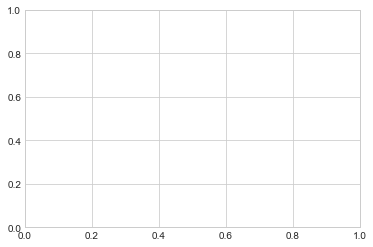

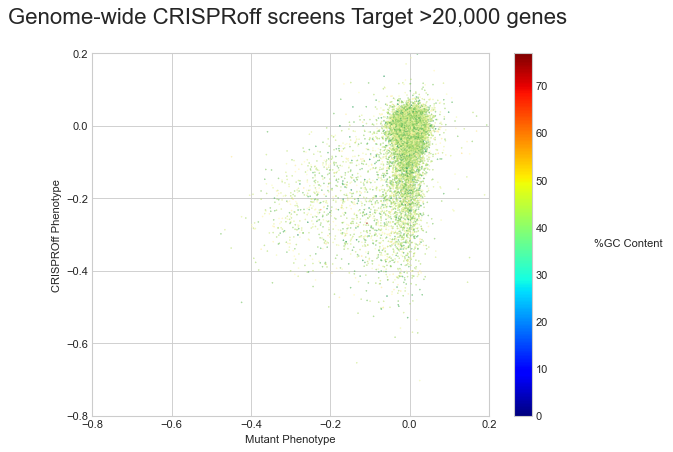

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.pyplot import figure

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

figure(figsize=(8, 6), dpi=80)

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['mutant_average'], df['CRISPRoff_average'], c = df.GC, cmap = "RdYlGn",s = 0.1)

normalize = mcolors.Normalize(vmin=df.GC.min(), vmax=df.GC.max())
colormap = cm.jet

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.GC)
plt.colorbar(scalarmappaple)

plt.legend(bbox_to_anchor=(1.35,0.5), borderaxespad=0, title="%GC Content",
                    loc= 'upper center', fontsize='small', fancybox=True,)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

plt.axis([-0.8,0.2,-0.8,0.2])
plt.savefig('Genome-wide %GC.eps', format = 'eps')


/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_52032/1064701637.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)


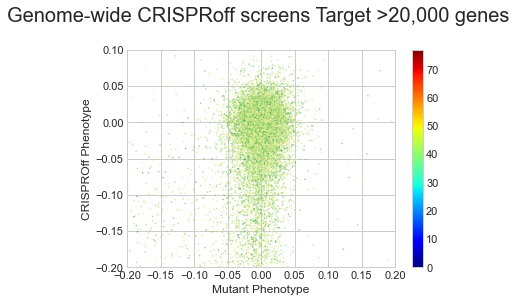

In [1106]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['mutant_average'], df['CRISPRoff_average'], c = df.GC, cmap = "RdYlGn",s = 0.1)

normalize = mcolors.Normalize(vmin=df.GC.min(), vmax=df.GC.max())
colormap = cm.jet

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.GC)
plt.colorbar(scalarmappaple)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

plt.axis([-0.2,0.2,-0.2,0.1])
plt.savefig('Genome-Wide %GC Zoom.eps', format = 'eps')


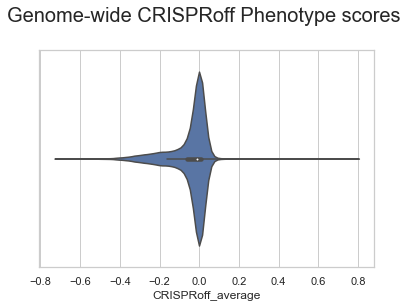

In [1107]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)
ax = sns.violinplot(x=df['CRISPRoff_average'])
plt.savefig('Violin plot.eps', format = 'eps')

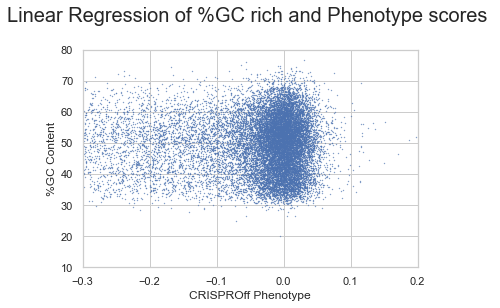

In [1108]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['CRISPRoff_average'], df['GC'], cmap = "RdYlGn",s = 0.1)

plt.xlabel('CRISPROff Phenotype')
plt.ylabel('%GC Content')

plt.title('Linear Regression of %GC rich and Phenotype scores \n', size = 20)

plt.axis([-0.3,0.2,10,80])
plt.savefig('Linear-regression_1.eps', format = 'eps')


### Linear Regression of the phenotype scores with their %GC

In [15]:
regression_data = df[['CRISPRoff_average','GC']].dropna()

coefficient of determination: 5.291085931502515e-05
slope: [0.60784422]
intercept: 52.680946652001


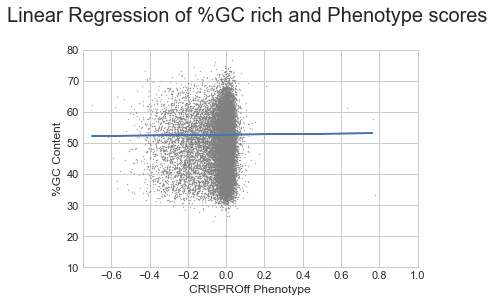

In [1109]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

x =  np.array(regression_data.CRISPRoff_average).reshape((-1,1))
y =  np.array(regression_data.GC)

model = LinearRegression()
model.fit(x,y)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)

m,b = np.polyfit(np.array(regression_data.CRISPRoff_average),y,1)

print('coefficient of determination:', r_sq)
print('slope:', model.coef_)
print('intercept:', model.intercept_)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['CRISPRoff_average'], df['GC'],s = 0.1, c = 'grey')


plt.title('Linear Regression of %GC rich and Phenotype scores \n', size = 20)
plt.xlabel('CRISPROff Phenotype')
plt.ylabel('%GC Content')
plt.plot(x, m*x + b)

plt.axis([-0.75,1,10,80])
plt.savefig('good.eps', format = 'eps')


### Essential Genes list across cell types

In [19]:
achilles = pd.read_csv('Achilles_common_essentials.csv',sep = '(',  header = 0)
achilles = achilles['genes']

In [29]:
achilles_scores = pd.merge(how = 'outer', left = achilles, right = cpgs, left_on = 'genes', right_on = 'gene')


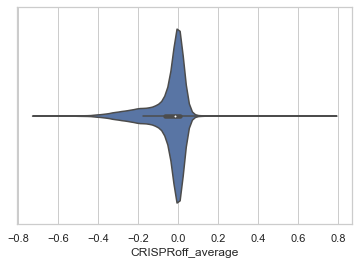

In [30]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=achilles_scores['CRISPRoff_average'])
plt.savefig('Essential Genes list.eps', format = 'eps')

In [31]:
achilles_cpgs = pd.merge(how = 'outer', left = achilles_scores, right = cpgs, left_on = 'genes', right_on = 'gene')
achilles_cpgs = achilles_cpgs.dropna()

In [32]:
achilles_cpgs

,genes,gene_x,CRISPRoff_average_x,mutant_average_x,gene_y,CRISPRoff_average_y,mutant_average_y
0,AAAS,AAAS,0.022066,0.033454,AAAS,0.022066,0.033454
1,AAMP,AAMP,-0.156843,-0.107485,AAMP,-0.156843,-0.107485
2,AARS,AARS,-0.262698,-0.276756,AARS,-0.262698,-0.276756
3,AARS2,AARS2,-0.143610,0.000784,AARS2,-0.143610,0.000784
4,AASDHPPT,AASDHPPT,-0.299343,-0.029740,AASDHPPT,-0.299343,-0.029740
...,...,...,...,...,...,...,...
2158,ZNRD1,ZNRD1,-0.264723,-0.206160,ZNRD1,-0.264723,-0.206160
2160,ZRANB2,ZRANB2,-0.113596,-0.040849,ZRANB2,-0.113596,-0.040849
2161,ZRSR2,ZRSR2,-0.162753,-0.028557,ZRSR2,-0.162753,-0.028557
2162,ZW10,ZW10,-0.245077,0.034984,ZW10,-0.245077,0.034984


In [33]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average','CpG']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
#cpgs['CpG'] = cpgs['CpG'].apply(lambda x:  1 if 'VERDADERO' else 0)

In [34]:
cpgs[cpgs.CpG == 'FALSO']

,gene,CRISPRoff_average,mutant_average,CpG
18757,44086,0.023959,0.017189,FALSO
18682,44088,0.023584,0.012517,FALSO
19763,44166,0.031839,0.025885,FALSO
18251,A1CF,0.021009,0.031239,FALSO
16516,A2M,0.012236,0.010139,FALSO
...,...,...,...,...
14459,ZSWIM1,0.003963,0.001552,FALSO
3162,ZSWIM3,-0.125409,0.001949,FALSO
12831,ZUFSP,-0.002342,-0.002830,FALSO
2729,ZWILCH,-0.148659,-0.113377,FALSO


In [35]:
achilles_cpgs = pd.merge(how = 'outer', left = achilles_scores, right = cpgs, left_on = 'genes', right_on = 'gene')
achilles_cpgs = achilles_cpgs.dropna()

In [36]:
achilles_cpgs

,genes,gene_x,CRISPRoff_average_x,mutant_average_x,gene_y,CRISPRoff_average_y,mutant_average_y,CpG
0,AAAS,AAAS,0.022066,0.033454,AAAS,0.022066,0.033454,VERDADERO
1,AAMP,AAMP,-0.156843,-0.107485,AAMP,-0.156843,-0.107485,VERDADERO
2,AARS,AARS,-0.262698,-0.276756,AARS,-0.262698,-0.276756,VERDADERO
3,AARS2,AARS2,-0.143610,0.000784,AARS2,-0.143610,0.000784,VERDADERO
4,AASDHPPT,AASDHPPT,-0.299343,-0.029740,AASDHPPT,-0.299343,-0.029740,VERDADERO
...,...,...,...,...,...,...,...,...
2158,ZNRD1,ZNRD1,-0.264723,-0.206160,ZNRD1,-0.264723,-0.206160,VERDADERO
2160,ZRANB2,ZRANB2,-0.113596,-0.040849,ZRANB2,-0.113596,-0.040849,VERDADERO
2161,ZRSR2,ZRSR2,-0.162753,-0.028557,ZRSR2,-0.162753,-0.028557,VERDADERO
2162,ZW10,ZW10,-0.245077,0.034984,ZW10,-0.245077,0.034984,VERDADERO


Genes without CpGs: 133
Genes with CpGs: 1866


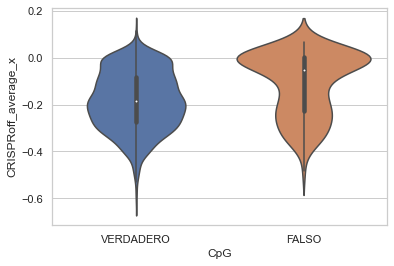

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

sns.violinplot(y='CRISPRoff_average_x', x="CpG",
              data=achilles_cpgs)

print('Genes without CpGs:', len(achilles_cpgs.CpG[achilles_cpgs.CpG == 'FALSO']))
print('Genes with CpGs:', len(achilles_cpgs.CpG[achilles_cpgs.CpG == 'VERDADERO']))

plt.savefig('Essential Genes list violin.eps', format = 'eps')

### IRRBS File

This track is produced as part of the ENCODE project. The track displays the methylation status of specific CpG dinucleotides in the given cell types as identified by the Illumina Infinium Human Methylation 450 Bead Array platform. In general, methylation of CpG sites within a promoter causes silencing of the gene associated with that promoter.

The Infinium Human Methylation 450 platform uses bisulfite treated genomic DNA to assay the methylation status of more than 450,000 CpG sites covering all designatable RefSeq genes, including promoter, 5' and 3' regions, without bias against those lacking CpG islands. Additionally, the assay includes CpG islands and shores, CpG sites outside of CpG islands, non-CpG methylated sites identified in human stem cells, differentially methylated sites identified in tumor versus normal (multiple forms of cancer) and across several tissue types, CpG islands outside of coding regions, miRNA promoter regions, and disease-associated regions identified through GWAS.

In [78]:
irbs = pd.read_csv('wgEncodeHaibMethylRrbsK562HaibSitesRep1.bed', sep='\t', header = 0)
irbs

,track,"name=""SL725","MspIRRBS""",K562_Rep3_RRBS,"MspIRRBS"".1",visibility=2,"name=""SL725.1","MspIRRBS"".2",Unnamed: 8,Unnamed: 9,Unnamed: 10
0,chr1,1000170,1000171,K562_Rep3_RRBS,46,+,1000170,1000171,"155,255,0",46,35
1,chr1,1000190,1000191,K562_Rep3_RRBS,46,+,1000190,1000191,"105,255,0",46,15
2,chr1,1000191,1000192,K562_Rep3_RRBS,53,-,1000191,1000192,"55,255,0",53,9
3,chr1,1000198,1000199,K562_Rep3_RRBS,46,+,1000198,1000199,"105,255,0",46,20
4,chr1,1000199,1000200,K562_Rep3_RRBS,53,-,1000199,1000200,"105,255,0",53,15
...,...,...,...,...,...,...,...,...,...,...,...
1275813,chrY,9930847,9930848,K562_Rep3_RRBS,28,-,9930847,9930848,"205,255,0",28,43
1275814,chrY,9930879,9930880,K562_Rep3_RRBS,28,-,9930879,9930880,"255,155,0",28,68
1275815,chrY,9982886,9982887,K562_Rep3_RRBS,5,+,9982886,9982887,"0,255,0",5,0
1275816,chrY,9987654,9987655,K562_Rep3_RRBS,7,+,9987654,9987655,"55,255,0",7,14


In [9]:
irbs.columns

Index(['track', 'name="SL725', 'MspIRRBS"', 'K562_Rep3_RRBS', 'MspIRRBS".1',
       'visibility=2', 'name="SL725.1', 'MspIRRBS".2', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')

Extract all the color values for each of the basepairs

In [47]:
col = irbs['Unnamed: 8'].str.split(',')

for i, x  in enumerate(col):
   col[i] = pd.to_numeric(col[i])/255

KeyboardInterrupt: 

Text(0.5, 1.0, 'DNA Methylation in Chromosomes for K562 hg19 bed file \n')

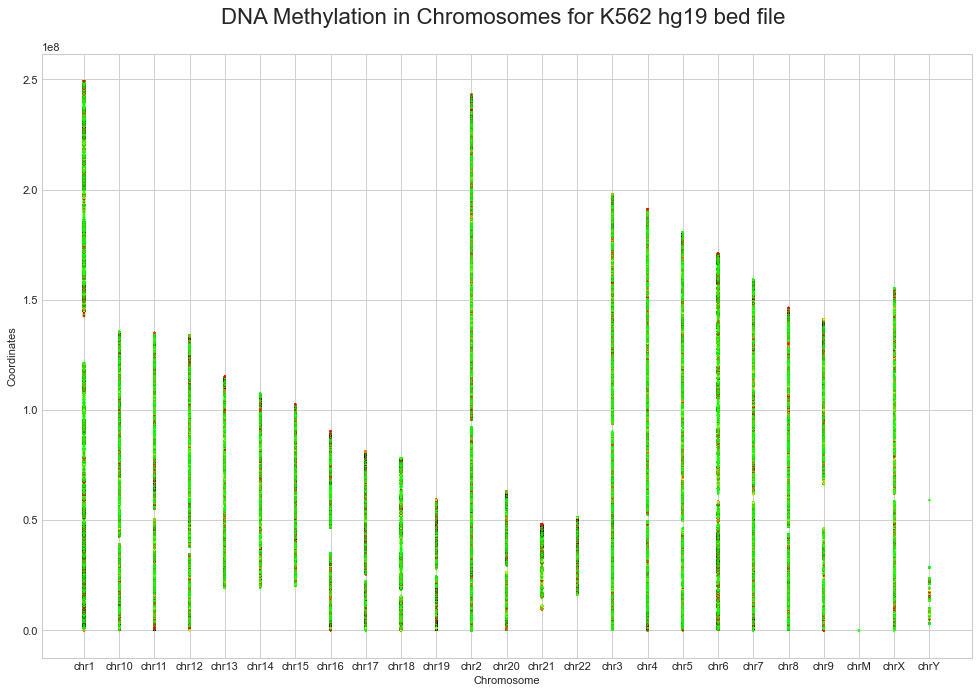

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.style.use('seaborn-whitegrid')

figure(figsize=(15, 10), dpi=80)

plt.scatter(irbs['track'], irbs['name="SL725'], c = col, s = 1)

plt.xlabel('Chromosome')
plt.ylabel('Coordinates')

plt.title('DNA Methylation in Chromosomes for K562 hg19 bed file \n', size = 20)

# plt.axis([-0.3,0.2,10,80])
# plt.savefig('Linear-regression_1.eps', format = 'eps')


Obtain all the RGB color values to plot them

In [276]:
col_keys = irbs['Unnamed: 8'].unique()

for i, x  in enumerate(col_keys):
    col_keys[i] = col_keys[i].split(',')

for i, x  in enumerate(col_keys):
   col_keys[i] = pd.to_numeric(col_keys[i])/255

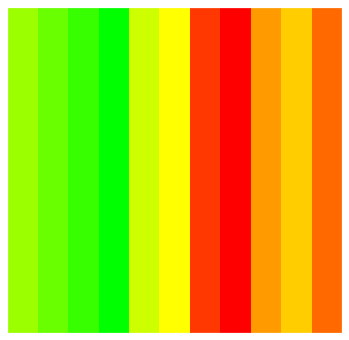

In [544]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

ax.axis(xmin=0, xmax=len(col_keys))
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

for index, colour in enumerate(col_keys):
    ax.axvspan(index, index + 1, color=colour)

#### Show only the methylation position at every basepair in the promoter sequence

Display Conventions and Configuration

Methylation status is represented with an 11-color gradient using the following convention:


- red = 100% of molecules sequenced are methylated

- yellow = 50% of molecules sequenced are methylated

- green = 0% of molecules sequenced are methylated


The score in this track reports the number of sequencing reads obtained for each CpG, which is often called 'coverage'. The score is capped at 1000, so any CpGs that were covered by more than 1000 sequencing reads have a score of 1000. The BED files available for download contain two extra columns: one with the uncapped coverage (number of reads at that site) and one with the percentage of those reads that show methylation. High reproducibility was obtained, with correlation coefficients greater than 0.9 between biological replicates, when only considering CpGs represented by at least 10 sequencing reads (10X coverage, score=10). Therefore, the default view for this track is set to 10X coverage, or a score of 10.

Metadata for a particular subtrack can be found by clicking the down arrow in the list of subtracks.

Description taken from: http://genome.ucsc.edu/cgi-bin/hgFileUi?db=hg19&g=wgEncodeHaibMethylRrbs#TRACK_HTML

In [48]:
# Extract only the Chromosome 1 

chr1_cpgs = irbs[irbs.track == 'chr1']

#Extract only the values with 100% Certainty of methylation 
chr1_cpgs = chr1_cpgs[chr1_cpgs['Unnamed: 8'] == '255,0,0']
chr1_cpgs

,track,"name=""SL725","MspIRRBS""",K562_Rep3_RRBS,"MspIRRBS"".1",visibility=2,"name=""SL725.1","MspIRRBS"".2",Unnamed: 8,Unnamed: 9,Unnamed: 10
35,chr1,100266424,100266425,K562_Rep3_RRBS,1,-,100266424,100266425,"255,0,0",1,100
36,chr1,100288780,100288781,K562_Rep3_RRBS,1,+,100288780,100288781,"255,0,0",1,100
37,chr1,100301433,100301434,K562_Rep3_RRBS,1,+,100301433,100301434,"255,0,0",1,100
39,chr1,1003026,1003027,K562_Rep3_RRBS,1,+,1003026,1003027,"255,0,0",1,100
40,chr1,1003038,1003039,K562_Rep3_RRBS,1,+,1003038,1003039,"255,0,0",1,100
...,...,...,...,...,...,...,...,...,...,...,...
116137,chr1,9984706,9984707,K562_Rep3_RRBS,1,+,9984706,9984707,"255,0,0",1,100
116141,chr1,998638,998639,K562_Rep3_RRBS,77,-,998638,998639,"255,0,0",77,96
116142,chr1,9988544,9988545,K562_Rep3_RRBS,7,+,9988544,9988545,"255,0,0",7,100
116143,chr1,9988545,9988546,K562_Rep3_RRBS,1,-,9988545,9988546,"255,0,0",1,100


In [65]:
# Extract only the Promoter sequences in Chromosome 1 

chr1_ps = Promoter_sequences[Promoter_sequences.chromosome == 'chr1']
chr1_ps

,Unnamed: 0,Gene,Sequences,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'",...,CpG_location,CpG_near_TSS,CpG_overlap_TSS,Mann-Whitney p-value,average phenotype of strongest 3,sgRNA count_MW,sgRNA count_avg,-log10 MW,discScore,thres
4,4.0,A3GALT2,CCTGCTATCGCCCCCAGGCCAGAAAATGTCATTTTGGACTTTGTCT...,A3GALT2,ENST00000442999.3,chr1,-,Annotation,33786698,33772367,...,[],False,False,0.881354,-0.007984,10.0,10.0,0.054850,0.022794,False
11,11.0,AADACL3,AAAAAAAAAAAAAGAAAGAAAGAAAGAATGCTTCAGGCTGGCTTCC...,AADACL3,P1P2,chr1,+,"CAGE, matched peaks",12776111,12776118,...,[],False,False,0.120085,0.029892,10.0,10.0,0.920512,1.432158,False
12,12.0,AADACL4,TAAAACATAAATAATAGGAATGAAAAAGGGGGTCTGCCTTCTAGTT...,AADACL4,P1P2,chr1,+,"CAGE, matched peaks",12704499,12704566,...,[],False,False,0.693022,-0.007294,10.0,10.0,0.159253,0.060457,False
37,37.0,ABCA4,CCTTCCTTTTTTTTCTTTCACAATGACTATGCGTAGCTTCTTAGAT...,ABCA4,P1P2,chr1,-,"CAGE, matched peaks",94586651,94511193,...,[],False,False,0.752349,0.009904,10.0,10.0,0.123581,0.063703,False
44,44.0,ABCB10,TCGCACCCAGCACAGGACCTAGCAAAATCGAAGATGCTCAGTAAAT...,ABCB10,P1P2,chr1,-,"CAGE, matched peaks",229694406,229652329,...,"[[229693772, 229695074]]",False,True,0.299914,-0.182862,10.0,10.0,0.523004,4.977752,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19151,19151.0,ZSCAN20,AGAAGGAATTTAAACTGGGTCGTTAAAGCTAAGAATTCTCCTATTT...,ZSCAN20,P1P2,chr1,+,"CAGE, matched peaks",33938236,33938252,...,"[[33938025, 33938328]]",False,True,0.750581,0.002161,10.0,10.0,0.124602,0.014017,False
19170,19170.0,ZSWIM5,GCAGTTACCAGAACGTGGCGCTGGCTTTGCTTCCAGGGAGTGTGTG...,ZSWIM5,P1P2,chr1,-,"CAGE, matched peaks",45672027,45482076,...,"[[45671702, 45672388]]",False,True,0.739781,0.002378,10.0,10.0,0.130897,0.016201,False
19181,19181.0,ZYG11A,ATTGGGCAAAAGCCGAGGAAATGACTGTAACTTTCCTTCATCCTCG...,ZYG11A,P1P2,chr1,+,"CAGE, matched peaks",53308425,53308183,...,"[[53308294, 53309262]]",False,True,0.877678,0.021245,10.0,10.0,0.056665,0.062657,False
19182,19182.0,ZYG11B,GAACTGAGGAGGATTTGATGTTAGCTAAAAGACAAATAATTAACTT...,ZYG11B,P1P2,chr1,+,"CAGE, matched peaks",53192114,53192131,...,"[[53192023, 53192428]]",False,True,0.010769,-0.039053,10.0,10.0,1.967841,3.999912,False


Create a vector full of zeros and then fill each position with correspondent position from the 5' Transcription start in Jin's file 

In [67]:
tmp = np.zeros((1982,3001))

for i, x in enumerate(chr1_cpgs['name="SL725.1']):
    for o, z in enumerate(chr1_ps["Primary TSS, 3'"]):
        if (x > (z - 1500) and (x < z + 1500)) == True:
            #print(x, z, 1500, x - (z - 1500))
            tmp[o][x - (z - 1500)] = 1

In [51]:
## Function to show each position for a certain gene

def methylated_basepairs(int):
    x = chr1_ps.head(int).tail(1)['Gene'].iloc[-1]
    print(x, "| Coordinates of TSS:", chr1_ps[chr1_ps['Gene'] == x]["Primary TSS, 3'"].iloc[-1])
    print("Found Methylated basepairs at positions:")
    print([np.where(tmp[int] == 1)][0][0] + chr1_ps[chr1_ps['Gene'] == x]["Primary TSS, 3'"].iloc[-1])
    plt.title("Methylation profile for promoter region of gene: {}".format(x), size = 15)
    plt.xlabel('Position of the bases | 1500 = Start of TSS ')
    plt.ylabel('Methylation')
    plt.plot(tmp[int])

In [70]:
print(chr1_ps[chr1_ps['gene'] == 'ACBD4']["Primary TSS, 3'"])
print('ACBD4' in errors)

Series([], Name: Primary TSS, 3', dtype: int64)
False


ZNF687 | Coordinates of TSS: 151254785
Found Methylated basepairs at positions:
[151256585]


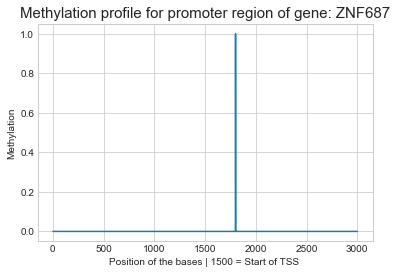

In [94]:
methylated_basepairs(1970)

In [145]:
# Are the predicted methylation sites C?  

def is_c(int):

    try:
        x = [np.where(tmp[int] == 1)][0][0]

        y = chr1_ps.head(int).tail(1)['Gene'].iloc[-1]

        if len(x) == 0:
            print("No Methylated Cs")
            
        for i in x:
            if list(chr1_ps.Sequences[chr1_ps['Gene'] == y].iloc[-1])[i] == 'C':
                print(i, 'is a C')
            else:
                print(i, 'is not a C, its a ' + list(chr1_ps.Sequences[chr1_ps['Gene'] == y].iloc[-1])[i])

    except:
        print("Issue with int", int, "Gene:")

In [133]:
#np.unique([np.where(tmp == 1)])
np.where(tmp == 1)

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    8,    8,    8,    8,    8,    8,
           8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,
           8,    9,   12,   14,   14,   14,   14,   14,   14,   14,   14,
          16,   22,   22,   23,   23,   23,   23,   23,   29,   29,   29,
          30,   30,   32,   34,   37,   38,   39,   42,   42,   42,   42,
          42,   42,   42,   42,   42,   42,   42,   42,   42,   42,   42,
          42,   42,   42,   42,   42,   42,   42,   42,   42,   42,   42,
          42,   42,   42,   42,   42,   42,   42,   42,   42,   42,   42,
          42,   42,   42,   42,   42,   42,   42,   42,   42,   42,   42,
          42,   42,   42,   42,   42,   42,   42,   42,   42,   42,   42,
          42,   42,   46,   46,   46,   46,   46,   46,   46,   46,   46,
          46,   46,   46,   46,   46,   46,   46,   46,   46,   46,   46,
          46,   46,   46,   46,   46, 

In [146]:
is_c(0)

Issue with int 0 Gene:
